In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [7]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
#         dy =  dy @ self.W_fixed[2].T # done
        dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
#             dy =  dy @ self.W_fixed[2].T # done
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
        dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [8]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3124, acc-0.1000, valid loss-2.3055, acc-0.1042, test loss-2.2996, acc-0.1094
Iter-20, train loss-2.3156, acc-0.0800, valid loss-2.3054, acc-0.1040, test loss-2.2995, acc-0.1096
Iter-30, train loss-2.3028, acc-0.1000, valid loss-2.3053, acc-0.1044, test loss-2.2994, acc-0.1097
Iter-40, train loss-2.2974, acc-0.1200, valid loss-2.3052, acc-0.1048, test loss-2.2992, acc-0.1099
Iter-50, train loss-2.2896, acc-0.1000, valid loss-2.3051, acc-0.1050, test loss-2.2991, acc-0.1099
Iter-60, train loss-2.2824, acc-0.1000, valid loss-2.3050, acc-0.1056, test loss-2.2990, acc-0.1103
Iter-70, train loss-2.3210, acc-0.1400, valid loss-2.3048, acc-0.1060, test loss-2.2989, acc-0.1103
Iter-80, train loss-2.2946, acc-0.0600, valid loss-2.3047, acc-0.1060, test loss-2.2987, acc-0.1105
Iter-90, train loss-2.2940, acc-0.1200, valid loss-2.3046, acc-0.1060, test loss-2.2986, acc-0.1106
Iter-100, train loss-2.3170, acc-0.0800, valid loss-2.3045, acc-0.1062, test loss-2.2985, acc-0.1112

Iter-830, train loss-2.2762, acc-0.2200, valid loss-2.2958, acc-0.1274, test loss-2.2895, acc-0.1304
Iter-840, train loss-2.3264, acc-0.0600, valid loss-2.2957, acc-0.1276, test loss-2.2894, acc-0.1307
Iter-850, train loss-2.2991, acc-0.0600, valid loss-2.2956, acc-0.1276, test loss-2.2893, acc-0.1312
Iter-860, train loss-2.3071, acc-0.1000, valid loss-2.2954, acc-0.1278, test loss-2.2891, acc-0.1313
Iter-870, train loss-2.2836, acc-0.1800, valid loss-2.2953, acc-0.1280, test loss-2.2890, acc-0.1317
Iter-880, train loss-2.3156, acc-0.0800, valid loss-2.2952, acc-0.1284, test loss-2.2889, acc-0.1316
Iter-890, train loss-2.2708, acc-0.2400, valid loss-2.2951, acc-0.1282, test loss-2.2888, acc-0.1318
Iter-900, train loss-2.2823, acc-0.1800, valid loss-2.2950, acc-0.1284, test loss-2.2887, acc-0.1320
Iter-910, train loss-2.2949, acc-0.1200, valid loss-2.2949, acc-0.1288, test loss-2.2885, acc-0.1323
Iter-920, train loss-2.2873, acc-0.0600, valid loss-2.2947, acc-0.1290, test loss-2.2884, a

Iter-1640, train loss-2.2805, acc-0.2200, valid loss-2.2865, acc-0.1446, test loss-2.2798, acc-0.1508
Iter-1650, train loss-2.2727, acc-0.1200, valid loss-2.2864, acc-0.1448, test loss-2.2797, acc-0.1508
Iter-1660, train loss-2.2608, acc-0.1200, valid loss-2.2863, acc-0.1450, test loss-2.2796, acc-0.1512
Iter-1670, train loss-2.2898, acc-0.1400, valid loss-2.2862, acc-0.1452, test loss-2.2795, acc-0.1512
Iter-1680, train loss-2.2604, acc-0.1600, valid loss-2.2860, acc-0.1456, test loss-2.2794, acc-0.1521
Iter-1690, train loss-2.2758, acc-0.2200, valid loss-2.2859, acc-0.1456, test loss-2.2792, acc-0.1529
Iter-1700, train loss-2.2775, acc-0.2200, valid loss-2.2858, acc-0.1464, test loss-2.2791, acc-0.1530
Iter-1710, train loss-2.2442, acc-0.3000, valid loss-2.2857, acc-0.1466, test loss-2.2790, acc-0.1532
Iter-1720, train loss-2.3109, acc-0.0800, valid loss-2.2856, acc-0.1466, test loss-2.2789, acc-0.1535
Iter-1730, train loss-2.2763, acc-0.1400, valid loss-2.2855, acc-0.1464, test loss

Iter-2450, train loss-2.2588, acc-0.1800, valid loss-2.2772, acc-0.1740, test loss-2.2702, acc-0.1762
Iter-2460, train loss-2.2818, acc-0.1800, valid loss-2.2771, acc-0.1742, test loss-2.2701, acc-0.1764
Iter-2470, train loss-2.2901, acc-0.1600, valid loss-2.2770, acc-0.1752, test loss-2.2700, acc-0.1770
Iter-2480, train loss-2.2794, acc-0.1600, valid loss-2.2769, acc-0.1752, test loss-2.2699, acc-0.1773
Iter-2490, train loss-2.2550, acc-0.2000, valid loss-2.2768, acc-0.1762, test loss-2.2698, acc-0.1778
Iter-2500, train loss-2.2595, acc-0.2400, valid loss-2.2767, acc-0.1758, test loss-2.2696, acc-0.1785
Iter-2510, train loss-2.2767, acc-0.2000, valid loss-2.2765, acc-0.1764, test loss-2.2695, acc-0.1792
Iter-2520, train loss-2.2889, acc-0.2200, valid loss-2.2764, acc-0.1772, test loss-2.2694, acc-0.1802
Iter-2530, train loss-2.2636, acc-0.1200, valid loss-2.2763, acc-0.1770, test loss-2.2693, acc-0.1806
Iter-2540, train loss-2.2359, acc-0.3800, valid loss-2.2762, acc-0.1776, test loss

Iter-3260, train loss-2.2499, acc-0.2200, valid loss-2.2681, acc-0.2036, test loss-2.2608, acc-0.2138
Iter-3270, train loss-2.2662, acc-0.2200, valid loss-2.2680, acc-0.2042, test loss-2.2607, acc-0.2145
Iter-3280, train loss-2.2559, acc-0.1800, valid loss-2.2679, acc-0.2044, test loss-2.2606, acc-0.2152
Iter-3290, train loss-2.2601, acc-0.2400, valid loss-2.2678, acc-0.2044, test loss-2.2604, acc-0.2152
Iter-3300, train loss-2.2827, acc-0.1600, valid loss-2.2677, acc-0.2052, test loss-2.2603, acc-0.2154
Iter-3310, train loss-2.3037, acc-0.1600, valid loss-2.2676, acc-0.2054, test loss-2.2602, acc-0.2157
Iter-3320, train loss-2.2246, acc-0.2400, valid loss-2.2674, acc-0.2054, test loss-2.2601, acc-0.2160
Iter-3330, train loss-2.2563, acc-0.2400, valid loss-2.2673, acc-0.2058, test loss-2.2600, acc-0.2160
Iter-3340, train loss-2.2612, acc-0.2400, valid loss-2.2672, acc-0.2066, test loss-2.2598, acc-0.2165
Iter-3350, train loss-2.2510, acc-0.3000, valid loss-2.2671, acc-0.2064, test loss

Iter-4070, train loss-2.2522, acc-0.2200, valid loss-2.2592, acc-0.2324, test loss-2.2516, acc-0.2367
Iter-4080, train loss-2.2093, acc-0.3600, valid loss-2.2591, acc-0.2322, test loss-2.2515, acc-0.2372
Iter-4090, train loss-2.2635, acc-0.2200, valid loss-2.2590, acc-0.2324, test loss-2.2514, acc-0.2370
Iter-4100, train loss-2.2456, acc-0.2400, valid loss-2.2589, acc-0.2322, test loss-2.2512, acc-0.2376
Iter-4110, train loss-2.2796, acc-0.1800, valid loss-2.2588, acc-0.2322, test loss-2.2511, acc-0.2376
Iter-4120, train loss-2.2422, acc-0.2600, valid loss-2.2587, acc-0.2330, test loss-2.2510, acc-0.2379
Iter-4130, train loss-2.2622, acc-0.1400, valid loss-2.2586, acc-0.2328, test loss-2.2509, acc-0.2380
Iter-4140, train loss-2.3024, acc-0.1200, valid loss-2.2585, acc-0.2330, test loss-2.2508, acc-0.2381
Iter-4150, train loss-2.2469, acc-0.2400, valid loss-2.2584, acc-0.2332, test loss-2.2507, acc-0.2383
Iter-4160, train loss-2.2684, acc-0.1400, valid loss-2.2583, acc-0.2338, test loss

Iter-4880, train loss-2.2414, acc-0.2600, valid loss-2.2505, acc-0.2470, test loss-2.2425, acc-0.2517
Iter-4890, train loss-2.2019, acc-0.3200, valid loss-2.2504, acc-0.2470, test loss-2.2424, acc-0.2518
Iter-4900, train loss-2.2781, acc-0.1800, valid loss-2.2503, acc-0.2470, test loss-2.2422, acc-0.2522
Iter-4910, train loss-2.2469, acc-0.2200, valid loss-2.2502, acc-0.2470, test loss-2.2421, acc-0.2525
Iter-4920, train loss-2.2713, acc-0.2000, valid loss-2.2500, acc-0.2474, test loss-2.2420, acc-0.2526
Iter-4930, train loss-2.2474, acc-0.2400, valid loss-2.2499, acc-0.2472, test loss-2.2419, acc-0.2529
Iter-4940, train loss-2.2611, acc-0.2800, valid loss-2.2498, acc-0.2484, test loss-2.2418, acc-0.2534
Iter-4950, train loss-2.2484, acc-0.2400, valid loss-2.2497, acc-0.2480, test loss-2.2417, acc-0.2535
Iter-4960, train loss-2.2882, acc-0.2600, valid loss-2.2496, acc-0.2480, test loss-2.2416, acc-0.2536
Iter-4970, train loss-2.2269, acc-0.2000, valid loss-2.2495, acc-0.2490, test loss

Iter-5690, train loss-2.2186, acc-0.2800, valid loss-2.2419, acc-0.2598, test loss-2.2335, acc-0.2633
Iter-5700, train loss-2.2561, acc-0.1400, valid loss-2.2418, acc-0.2602, test loss-2.2334, acc-0.2636
Iter-5710, train loss-2.2008, acc-0.3200, valid loss-2.2416, acc-0.2602, test loss-2.2333, acc-0.2638
Iter-5720, train loss-2.2433, acc-0.2000, valid loss-2.2415, acc-0.2608, test loss-2.2332, acc-0.2635
Iter-5730, train loss-2.2616, acc-0.2200, valid loss-2.2414, acc-0.2610, test loss-2.2331, acc-0.2636
Iter-5740, train loss-2.1989, acc-0.4200, valid loss-2.2413, acc-0.2612, test loss-2.2330, acc-0.2635
Iter-5750, train loss-2.2099, acc-0.4000, valid loss-2.2412, acc-0.2608, test loss-2.2329, acc-0.2637
Iter-5760, train loss-2.2603, acc-0.2600, valid loss-2.2411, acc-0.2604, test loss-2.2327, acc-0.2641
Iter-5770, train loss-2.2655, acc-0.1800, valid loss-2.2410, acc-0.2608, test loss-2.2326, acc-0.2638
Iter-5780, train loss-2.2616, acc-0.2800, valid loss-2.2409, acc-0.2610, test loss

Iter-6500, train loss-2.2136, acc-0.3000, valid loss-2.2333, acc-0.2698, test loss-2.2247, acc-0.2734
Iter-6510, train loss-2.2285, acc-0.2000, valid loss-2.2332, acc-0.2702, test loss-2.2246, acc-0.2736
Iter-6520, train loss-2.2523, acc-0.2200, valid loss-2.2331, acc-0.2704, test loss-2.2245, acc-0.2738
Iter-6530, train loss-2.2060, acc-0.3600, valid loss-2.2330, acc-0.2702, test loss-2.2244, acc-0.2740
Iter-6540, train loss-2.2029, acc-0.4000, valid loss-2.2329, acc-0.2702, test loss-2.2242, acc-0.2741
Iter-6550, train loss-2.2149, acc-0.2200, valid loss-2.2328, acc-0.2708, test loss-2.2241, acc-0.2745
Iter-6560, train loss-2.2091, acc-0.3200, valid loss-2.2327, acc-0.2704, test loss-2.2240, acc-0.2742
Iter-6570, train loss-2.2066, acc-0.2800, valid loss-2.2326, acc-0.2710, test loss-2.2239, acc-0.2744
Iter-6580, train loss-2.2816, acc-0.1800, valid loss-2.2325, acc-0.2716, test loss-2.2238, acc-0.2743
Iter-6590, train loss-2.2493, acc-0.2400, valid loss-2.2324, acc-0.2714, test loss

Iter-7310, train loss-2.2201, acc-0.2400, valid loss-2.2250, acc-0.2792, test loss-2.2160, acc-0.2821
Iter-7320, train loss-2.1524, acc-0.4400, valid loss-2.2249, acc-0.2792, test loss-2.2159, acc-0.2825
Iter-7330, train loss-2.2483, acc-0.2000, valid loss-2.2248, acc-0.2798, test loss-2.2158, acc-0.2827
Iter-7340, train loss-2.1997, acc-0.3600, valid loss-2.2247, acc-0.2800, test loss-2.2157, acc-0.2829
Iter-7350, train loss-2.2232, acc-0.3000, valid loss-2.2246, acc-0.2800, test loss-2.2156, acc-0.2833
Iter-7360, train loss-2.2235, acc-0.3400, valid loss-2.2245, acc-0.2800, test loss-2.2155, acc-0.2837
Iter-7370, train loss-2.2246, acc-0.2400, valid loss-2.2244, acc-0.2800, test loss-2.2154, acc-0.2836
Iter-7380, train loss-2.2081, acc-0.2600, valid loss-2.2243, acc-0.2802, test loss-2.2153, acc-0.2837
Iter-7390, train loss-2.2263, acc-0.3000, valid loss-2.2242, acc-0.2804, test loss-2.2152, acc-0.2838
Iter-7400, train loss-2.1590, acc-0.3600, valid loss-2.2241, acc-0.2806, test loss

Iter-8120, train loss-2.2173, acc-0.2800, valid loss-2.2167, acc-0.2884, test loss-2.2075, acc-0.2918
Iter-8130, train loss-2.2317, acc-0.1800, valid loss-2.2166, acc-0.2882, test loss-2.2074, acc-0.2918
Iter-8140, train loss-2.1982, acc-0.2200, valid loss-2.2165, acc-0.2882, test loss-2.2073, acc-0.2918
Iter-8150, train loss-2.1606, acc-0.3600, valid loss-2.2164, acc-0.2882, test loss-2.2072, acc-0.2918
Iter-8160, train loss-2.2384, acc-0.2800, valid loss-2.2163, acc-0.2880, test loss-2.2071, acc-0.2920
Iter-8170, train loss-2.1625, acc-0.3600, valid loss-2.2162, acc-0.2880, test loss-2.2070, acc-0.2919
Iter-8180, train loss-2.1997, acc-0.3200, valid loss-2.2161, acc-0.2882, test loss-2.2069, acc-0.2920
Iter-8190, train loss-2.1832, acc-0.3400, valid loss-2.2160, acc-0.2884, test loss-2.2068, acc-0.2925
Iter-8200, train loss-2.2015, acc-0.3200, valid loss-2.2159, acc-0.2884, test loss-2.2067, acc-0.2925
Iter-8210, train loss-2.1750, acc-0.4400, valid loss-2.2158, acc-0.2884, test loss

Iter-8930, train loss-2.2100, acc-0.2600, valid loss-2.2086, acc-0.2960, test loss-2.1991, acc-0.3006
Iter-8940, train loss-2.2084, acc-0.2600, valid loss-2.2085, acc-0.2958, test loss-2.1990, acc-0.3006
Iter-8950, train loss-2.1764, acc-0.4200, valid loss-2.2084, acc-0.2956, test loss-2.1989, acc-0.3009
Iter-8960, train loss-2.1943, acc-0.2200, valid loss-2.2083, acc-0.2958, test loss-2.1988, acc-0.3008
Iter-8970, train loss-2.2043, acc-0.3000, valid loss-2.2082, acc-0.2964, test loss-2.1987, acc-0.3010
Iter-8980, train loss-2.1681, acc-0.3800, valid loss-2.2081, acc-0.2964, test loss-2.1986, acc-0.3009
Iter-8990, train loss-2.1680, acc-0.4000, valid loss-2.2080, acc-0.2964, test loss-2.1985, acc-0.3009
Iter-9000, train loss-2.2365, acc-0.2600, valid loss-2.2080, acc-0.2964, test loss-2.1984, acc-0.3010
Iter-9010, train loss-2.1436, acc-0.4000, valid loss-2.2078, acc-0.2962, test loss-2.1983, acc-0.3011
Iter-9020, train loss-2.2081, acc-0.3000, valid loss-2.2078, acc-0.2964, test loss

Iter-9740, train loss-2.2413, acc-0.1400, valid loss-2.2007, acc-0.3028, test loss-2.1909, acc-0.3086
Iter-9750, train loss-2.1831, acc-0.2800, valid loss-2.2006, acc-0.3032, test loss-2.1908, acc-0.3084
Iter-9760, train loss-2.1797, acc-0.3400, valid loss-2.2005, acc-0.3032, test loss-2.1907, acc-0.3087
Iter-9770, train loss-2.2117, acc-0.3600, valid loss-2.2004, acc-0.3034, test loss-2.1906, acc-0.3086
Iter-9780, train loss-2.2006, acc-0.3200, valid loss-2.2003, acc-0.3032, test loss-2.1905, acc-0.3084
Iter-9790, train loss-2.2025, acc-0.2800, valid loss-2.2002, acc-0.3034, test loss-2.1904, acc-0.3085
Iter-9800, train loss-2.1458, acc-0.4000, valid loss-2.2001, acc-0.3032, test loss-2.1903, acc-0.3085
Iter-9810, train loss-2.2016, acc-0.3800, valid loss-2.2000, acc-0.3032, test loss-2.1902, acc-0.3086
Iter-9820, train loss-2.1599, acc-0.3200, valid loss-2.1999, acc-0.3034, test loss-2.1901, acc-0.3088
Iter-9830, train loss-2.2141, acc-0.2000, valid loss-2.1998, acc-0.3038, test loss

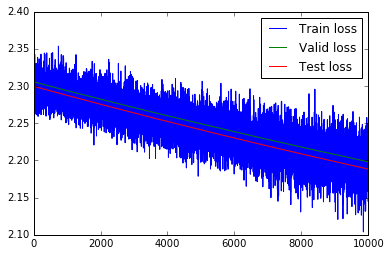

In [9]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

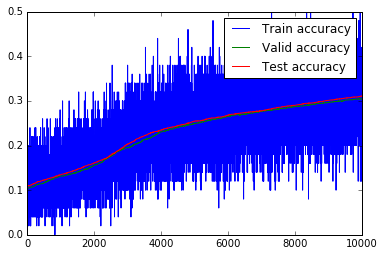

In [10]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()